In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as  plt
%matplotlib inline

defenders = pd.read_csv(r'C:\Users\sosan\Documents\Dissertation\DataSets\Fifa 20\TransformedData\Defenders.csv')
defenders.head(5)

,Name,Image,Country,Position,Age,Overall,Potential,Club,ID,Height,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,Virgil van Dijk,https://cdn.sofifa.org/players/4/20/203376.png,Netherlands,CB,27,90,90,Liverpool,203376,193.0,...,Medium,Medium,3,77,60,70,71,90,86,425
1,Kalidou Koulibaly,https://cdn.sofifa.org/players/4/20/201024.png,Senegal,CB,28,89,89,Napoli,201024,188.0,...,Medium,High,3,71,28,54,67,89,87,303
2,Sergio Ramos García,https://cdn.sofifa.org/players/4/20/155862.png,Spain,CB,33,89,89,Real Madrid,155862,182.9,...,High,Medium,4,72,68,75,73,87,85,211
3,Giorgio Chiellini,https://cdn.sofifa.org/players/4/20/138956.png,Italy,CB,34,89,89,Juventus,138956,188.0,...,Medium,High,4,68,46,58,60,90,82,106
4,Diego Godín,https://cdn.sofifa.org/players/4/20/182493.png,Uruguay,CB,33,88,88,Inter,182493,188.0,...,Medium,High,3,60,48,64,61,89,83,103


In [6]:
defenders = defenders.drop(['Image','ID','A/W','D/W','Release Clause','Hits','Joined','Total Stats','Loan Date End', 'Release Clause','Position','Wage','Value','Name', 'BOV', 'Potential','Club'], axis = 1)

In [7]:
defenders.loc[defenders['BP'] == 'CB', 'BP'] = 0
defenders.loc[(defenders['BP'] == 'LB') | (defenders['BP'] == 'LWB'), 'BP'] = 1
defenders.loc[(defenders['BP'] == 'RB') | (defenders['BP'] == 'RWB'), 'BP'] = 2
defenders['BP'].head(10)

defenders.loc[defenders['foot'] == 'Right', 'foot'] = 1
defenders.loc[defenders['foot'] == 'Left', 'foot'] = 0

In [8]:
#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)
nat_counts = defenders.Country.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df):
    if (df.Country in nat_list):
        return 1
    else:
        return 0

#Create a copy of the original dataframe to avoid indexing errors
defenders1 = defenders.copy()

defenders1['Major_Nation'] = defenders1.apply(major_nation,axis = 1)

#Drop original columns used
defenders1 = defenders1.drop(['Country'], axis = 1)
defenders1.head()



,Age,Overall,Height,Weight,foot,BP,Growth,Attacking,Crossing,Finishing,...,W/F,SM,IR,PAC,SHO,PAS,DRI,DEF,PHY,Major_Nation
0,27,90,193.0,92.3,1,0,1,314,53,52,...,3,2,3,77,60,70,71,90,86,0
1,28,89,188.0,89.1,1,0,2,220,30,22,...,3,2,3,71,28,54,67,89,87,0
2,33,89,182.9,82.3,1,0,0,370,66,63,...,3,3,4,72,68,75,73,87,85,1
3,34,89,188.0,85.0,0,0,0,280,54,33,...,3,2,4,68,46,58,60,90,82,0
4,33,88,188.0,78.2,1,0,0,308,52,42,...,3,2,3,60,48,64,61,89,83,0


In [9]:
#Split ID as a Target value
target = defenders1.Overall
explanatory_var = defenders1.drop(['Overall'], axis = 1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(explanatory_var, target, test_size=0.2)

#One Hot Encoding
#x_train = pd.get_dummies(x_train)
#x_test = pd.get_dummies(x_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4923, 58) (4923,)
(1231, 58) (1231,)


In [10]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print(predictions[:10])
print(y_test[:10])
#Finding the r2 score and root mean squared error
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

[64.26639415 57.12286054 58.40410639 66.37532478 65.36192368 51.83211524
 68.41645555 65.09754014 65.42731412 70.17677817]
3735    64
5663    57
5373    59
4202    63
4023    64
6062    51
1937    69
3268    66
2946    66
1579    70
Name: Overall, dtype: int64
r2 score: 0.9750484707610668
RMSE : 1.0425903480593715


In [12]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.2013 ± 0.0162,Defending
0.0603 ± 0.0051,DRI
0.0431 ± 0.0037,Skill
0.0358 ± 0.0035,Movement
0.0348 ± 0.0054,Interceptions
0.0299 ± 0.0022,Mentality
0.0169 ± 0.0029,Ball Control
0.0124 ± 0.0008,BP
0.0120 ± 0.0011,Crossing
0.0113 ± 0.0007,Attacking


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.inspection import permutation_importance

rf_reg_model = RandomForestRegressor(random_state=1, max_depth=10)
sgd_reg_model = SGDRegressor(random_state=1, max_iter=10)

rf_reg_model.fit(x_train, y_train)
sgd_reg_model.fit(x_train, y_train)

important_feat = rf_reg_model.feature_importances_

sgd_reg_model.fit(x_train, y_train)
# perform permutation importance
results = permutation_importance(sgd_reg_model, x_train, y_train, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean.argsort()

print(importance)

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

indices = np.argsort(important_feat)[-15:]  # top 10 features

print(indices)

[17  6  8 21 54 35 22 23 16 40 41 42 52 11 32 27 38 43 26 12  5 56 49  4
 18 57 48 55  3 50 44 37 45 46  9 34  0 13 20 53  2 14 36 28 39 10 51  1
 15 25 24 33 19 31 29 47  7 30]
Feature: 0, Score: 17.00000
Feature: 1, Score: 6.00000
Feature: 2, Score: 8.00000
Feature: 3, Score: 21.00000
Feature: 4, Score: 54.00000
Feature: 5, Score: 35.00000
Feature: 6, Score: 22.00000
Feature: 7, Score: 23.00000
Feature: 8, Score: 16.00000
Feature: 9, Score: 40.00000
Feature: 10, Score: 41.00000
Feature: 11, Score: 42.00000
Feature: 12, Score: 52.00000
Feature: 13, Score: 11.00000
Feature: 14, Score: 32.00000
Feature: 15, Score: 27.00000
Feature: 16, Score: 38.00000
Feature: 17, Score: 43.00000
Feature: 18, Score: 26.00000
Feature: 19, Score: 12.00000
Feature: 20, Score: 5.00000
Feature: 21, Score: 56.00000
Feature: 22, Score: 49.00000
Feature: 23, Score: 4.00000
Feature: 24, Score: 18.00000
Feature: 25, Score: 57.00000
Feature: 26, Score: 48.00000
Feature: 27, Score: 55.00000
Feature: 28, Score: 3.00

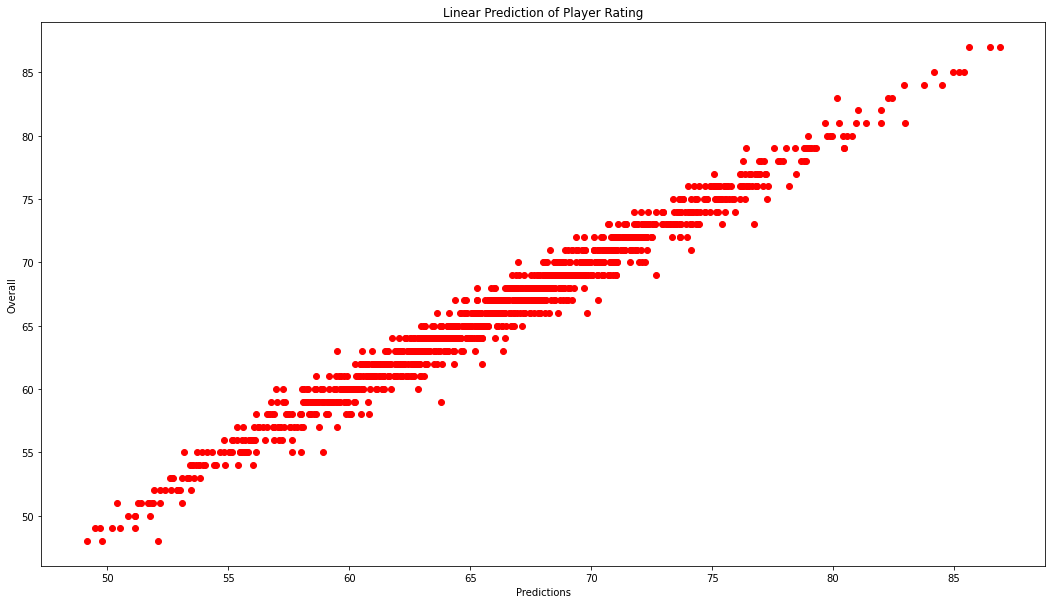

In [15]:
#import plotter
import seaborn as sns

import matplotlib.pyplot as  plt
%matplotlib inline

#Visualising the results
plt.figure(figsize=(18,10))
plt.scatter(predictions, y_test, color = "red")
#plt.plot(predictions, y_test, color = "green")
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

In [16]:
indexes = defenders1._get_numeric_data().columns
print(indexes)

Index(['Age', 'Overall', 'Height', 'Weight', 'Growth', 'Attacking', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality', 'Aggression', 'Interceptions', 'Positioning',
       'Vision', 'Penalties', 'Composure', 'Defending', 'Marking',
       'Standing Tackle', 'Sliding Tackle', 'Goalkeeping', 'GK Diving',
       'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes',
       'Base Stats', 'W/F', 'SM', 'IR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF',
       'PHY', 'Major_Nation'],
      dtype='object')


In [17]:
defending_features = ['Age', 'Height', 'Weight', 'Growth', 'Attacking', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality', 'Aggression', 'Interceptions', 'Positioning',
       'Vision', 'Penalties', 'Composure', 'Defending', 'Marking',
       'Standing Tackle', 'Sliding Tackle', 'Goalkeeping', 'GK Diving',
       'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes',
       'Base Stats', 'W/F', 'SM', 'IR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF',
       'PHY']
normalize_data = defenders1

In [18]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
normalize_data[defending_features] =  min_max.fit_transform(normalize_data[defending_features])
#df_scaled = pd.DataFrame(player, columns=numerical_Data.columns,index=numerical_Data.index)
normalize_data.head(5)

,Age,Overall,Height,Weight,foot,BP,Growth,Attacking,Crossing,Finishing,...,W/F,SM,IR,PAC,SHO,PAS,DRI,DEF,PHY,Major_Nation
0,0.44,90,0.776805,0.822957,1,0,0.04,0.704981,0.531646,0.646154,...,0.5,0.0,0.666667,0.746479,0.725806,0.766667,0.786885,1.000000,0.938776,0
1,0.48,89,0.667396,0.760700,1,0,0.08,0.344828,0.240506,0.184615,...,0.5,0.0,0.666667,0.661972,0.209677,0.500000,0.721311,0.979592,0.959184,0
2,0.68,89,0.555799,0.628405,1,0,0.00,0.919540,0.696203,0.815385,...,0.5,0.5,1.000000,0.676056,0.854839,0.850000,0.819672,0.938776,0.918367,1
3,0.72,89,0.667396,0.680934,0,0,0.00,0.574713,0.544304,0.353846,...,0.5,0.0,1.000000,0.619718,0.500000,0.566667,0.606557,1.000000,0.857143,0
4,0.68,88,0.667396,0.548638,1,0,0.00,0.681992,0.518987,0.492308,...,0.5,0.0,0.666667,0.507042,0.532258,0.666667,0.622951,0.979592,0.877551,0


In [20]:
#Split ID as a Target value
n_target = normalize_data.Overall
n_explanatory_var = normalize_data.drop(['Overall'], axis = 1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
n_x_train, n_x_test, n_y_train, n_y_test = train_test_split(n_explanatory_var, n_target, test_size=0.2)

#One Hot Encoding
#x_train = pd.get_dummies(x_train)
#x_test = pd.get_dummies(x_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(n_y_test.head(10))

(4923, 58) (4923,)
(1231, 58) (1231,)
3852    64
2786    67
5910    54
2010    69
269     78
418     76
2324    68
107     80
6055    52
4117    64
Name: Overall, dtype: int64


In [21]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
n_model = LinearRegression()
n_model.fit(n_x_train, n_y_train)
n_predictions = n_model.predict(n_x_test)

print(n_predictions[:10])
print(n_y_test[:10])
#Finding the r2 score and root mean squared error
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: '+str(r2_score(n_y_test, n_predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(n_y_test, n_predictions))))

[62.68383026 67.50719452 53.86528778 68.97316742 77.76290131 75.13726044
 66.25972748 80.5009079  51.84493256 64.02147675]
3852    64
2786    67
5910    54
2010    69
269     78
418     76
2324    68
107     80
6055    52
4117    64
Name: Overall, dtype: int64
r2 score: 0.9728272464301461
RMSE : 1.0891841552425452


In [22]:
n_perm = PermutationImportance(n_model, random_state=1).fit(n_x_test, n_y_test)
eli5.show_weights(n_perm, feature_names = n_x_test.columns.tolist())

Weight,Feature
3697723354545738743808.0000 ± 102238947284638973952.0000,Mentality
1747073541385700245504.0000 ± 58474049348113162240.0000,Skill
1245530094448636854272.0000 ± 30123485858196365312.0000,Power
665161210217102049280.0000 ± 26206979653522309120.0000,Base Stats
471522675794132795392.0000 ± 23588401378048196608.0000,Positioning
334643612661480357888.0000 ± 28967402077919531008.0000,Vision
257722600821655502848.0000 ± 8527390991139892224.0000,Aggression
254827308518268207104.0000 ± 16554386095109066752.0000,Penalties
205623169131114627072.0000 ± 10760016700018966528.0000,Defending
189623616223837618176.0000 ± 8971804625615805440.0000,Long Shots
